In [11]:
%reload_ext autoreload
import os
# curr_dir = "/home/mushaikh/private/PointCloudPosePrediction"
# os.chdir(curr_dir)
os.chdir("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction")
import importlib
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import open3d as o3d
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R
import tqdm
from typing import Any, Callable, Optional, Tuple
import yaml
import cv2
import matplotlib.pyplot as plt
import core.pointnet as pnet
import core.deep_pose_estimator as dpe
importlib.reload(dpe)
importlib.reload(pnet)
import core.deep_pose_estimator as dpe
import utils.dataloader
import utils.utils
import utils.vision
importlib.reload(utils.utils)
importlib.reload(utils.vision)
importlib.reload(utils.dataloader)

<module 'utils.dataloader' from '/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction/utils/dataloader.py'>

In [12]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [13]:
# load params for current model run; choose model run below after creating yaml file for it
with open("./models/run_1.yaml") as f:
    params = yaml.safe_load(f)

In [14]:
# create data loader for Eden data - outputs pairs of point clouds and relative poses
batch_size = 64
# "/home/mushaikh/private/sample"
dataset=utils.dataloader.EdenDataset("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample",
                                            train=True,
                                            keypt_method=params['keypoint_detection']['detection_method'],
                                            pcd_num_pts = params['keypoint_detection']['pcd_num_pts']
                                            )
edenLoader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [5]:
# create a batch for dev/testing purposes
batch = next(iter(edenLoader))

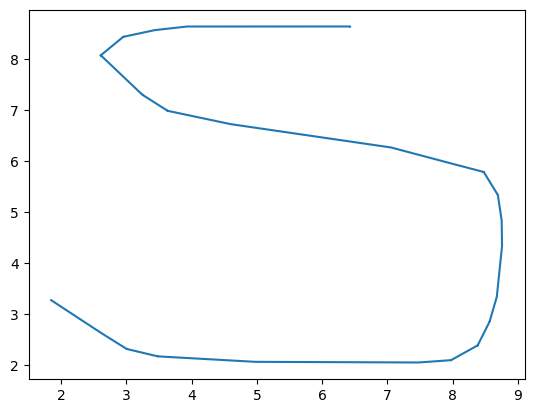

In [6]:
# visualize the trajectory of the ground truth sequence
positions = np.zeros((500, 3))
for j in range(100):
    positions[j] = utils.utils.invert_pose(dataset[j]['pose'])[:3,3]

plt.plot(positions[:100,0],positions[:100,1])
plt.show()

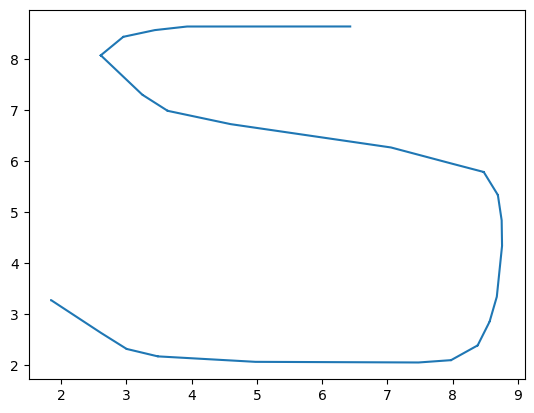

In [122]:
# visualize the trajectory of the relative poses applied to initial pose
positions = np.zeros((500, 3))
init = utils.utils.invert_pose(dataset[0]['pose'])
for j in range(100):
    positions[j] = init[0:3,3]
    init = (dataset[j]['rel_pose'].numpy()) @ init

plt.plot(positions[:100,0],positions[:100,1])
plt.show()

### PointNet - extract feature vector, reduce dimensions, visualize results

In [37]:
# for testing only - nx128 feature vector from combined global and local features from segmentation branch
batch_feat_vec128 = dpe.DeepPoseEstimator()(batch['pcd1'].permute(0,2,1), batch['pcd2'].permute(0,2,1))
batch_feat_vec128 = batch_feat_vec128.permute(0,2,1)

In [15]:
# training loop
model = dpe.DeepPoseEstimator()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
num_batch = len(dataset) / batch_size

for epoch in range(params['epochs']):
    scheduler.step()
    for i, data in enumerate(edenLoader, 0):

        pcd1, pcd2, quat, translation = data["pcd1"], data["pcd2"], data["quat"], data["translation"]
        target = torch.cat((translation.transpose(1,0), quat.transpose(1,0))).transpose(1,0)
        # move to gpu
        pcd1, pcd2, quat, translation = pcd1.to(device), pcd2.to(device), quat.to(device), translation.to(device)
        # reset gradients
        optimizer.zero_grad()
        model.train(True)
        # get preds from model
        pred, trans_feat_1, trans_feat_2 = model(pcd1, pcd2) # predicts 7-length vector of translation/quaternion
        # compute loss
        loss = dpe.PoseLoss(pred, target) + \
            pnet.feature_transform_regularizer(trans_feat_1) * 0.001 + \
                pnet.feature_transform_regularizer(trans_feat_1) * 0.001
        # backward pass
        loss.backward()
        # gradient descent step 
        optimizer.step()

        print('[%d: %d/%d] train loss: %f' % (epoch, i, num_batch, loss.item()))



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff18c650c10>
Traceback (most recent call last):
  File "/Users/mustafa/miniconda3/envs/ece276/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Users/mustafa/miniconda3/envs/ece276/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/mustafa/miniconda3/envs/ece276/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/mustafa/miniconda3/envs/ece276/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/mustafa/miniconda3/envs/ece276/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/mustafa/miniconda3/envs/ece276/lib/python3.9/selectors.py", line 416,

RuntimeError: Given groups=1, weight of size [64, 3, 1], expected input[64, 2000, 3] to have 3 channels, but got 2000 channels instead